In [1]:
import pandas as pd
import missingno as msno
import numpy as np
from numpy import nan
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt 
from math import radians,cos,sin
import time
from sklearn.preprocessing import LabelEncoder, StandardScaler
from IPython.display import display
from scipy.stats import boxcox
from scipy.stats import norm
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit
%matplotlib inline   
import warnings  #ignore all the warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, make_scorer, fbeta_score
#from catboost import Pool, CatBoostClassifier, cv, CatboostIpythonWidget
from itertools import combinations
import xgboost as xgb
from sklearn.model_selection import cross_val_score as cv_s
#from bayes_opt import BayesianOptimization as BayesOpt
import operator
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.utils import shuffle

# 0. Initial Data Exploration

In [2]:
train = pd.read_csv('training_set_values.csv')
test = pd.read_csv('test_set_values.csv')
training_labels = pd.read_csv('training_set_labels.csv')

train.shape

(59400, 40)

In [8]:
test.shape

(14850, 40)

In [9]:
train.sample(5)
#all latitude longitude values were imputed from external data; so there are no missing or 0 values in longitude and latitude

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
9979,32337,0.0,2013-02-14,District Council,701,District Council,37.561210,-3.502461e+00,Kwa Chilambo,0,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
22943,25495,0.0,2011-08-17,Hesawa,0,DWE,0.000000,-2.000000e-08,Bomakamuli,0,...,unknown,unknown,unknown,dry,dry,machine dbh,borehole,groundwater,other,other
26739,26826,0.0,2011-02-19,Unicef,90,RDC,39.166777,-7.629126e+00,Nyampwemwende,0,...,never pay,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
34805,34653,0.0,2013-03-11,NaN,1289,NaN,36.556494,-3.459654e+00,Kipok Secondary School,0,...,never pay,soft,good,seasonal,seasonal,spring,spring,groundwater,communal standpipe,communal standpipe
57162,49197,500.0,2013-03-24,Government Of Tanzania,2067,DWE,36.656241,-3.226663e+00,Kandaskilieti,0,...,on failure,soft,good,insufficient,insufficient,spring,spring,groundwater,improved spring,improved spring


## Checking for Missing Data and Visualizing the Spread

In [3]:
NAs = pd.concat([train.isnull().sum(), test.isnull().sum()], axis=1, keys=['Train', 'Test'])
NAs[NAs.sum(axis=1) > 0]
display(NAs)

,Train,Test
id,0,0
amount_tsh,0,0
date_recorded,0,0
funder,3635,869
gps_height,0,0
installer,3655,877
longitude,0,0
latitude,0,0
wpt_name,0,0
num_private,0,0


## Checking Initial correlations in Numerical Features

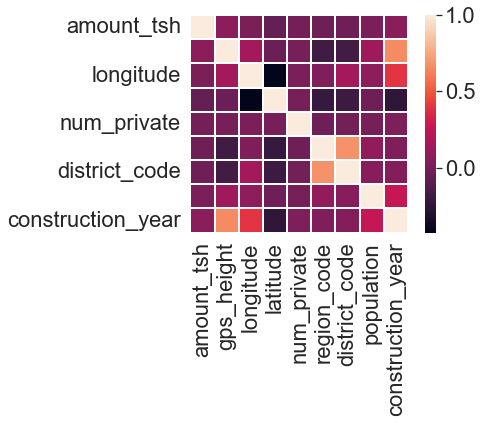

In [4]:
corr = train.select_dtypes(include = ['float64', 'int64']).iloc[:,1:].corr()
sns.set(font_scale=2)  
sns.heatmap(corr,  linewidths=0.3, square=True)
plt.rcParams["figure.figsize"] = (30,20)
plt.show()

## Checking Distribution of Target Variable in Training Data

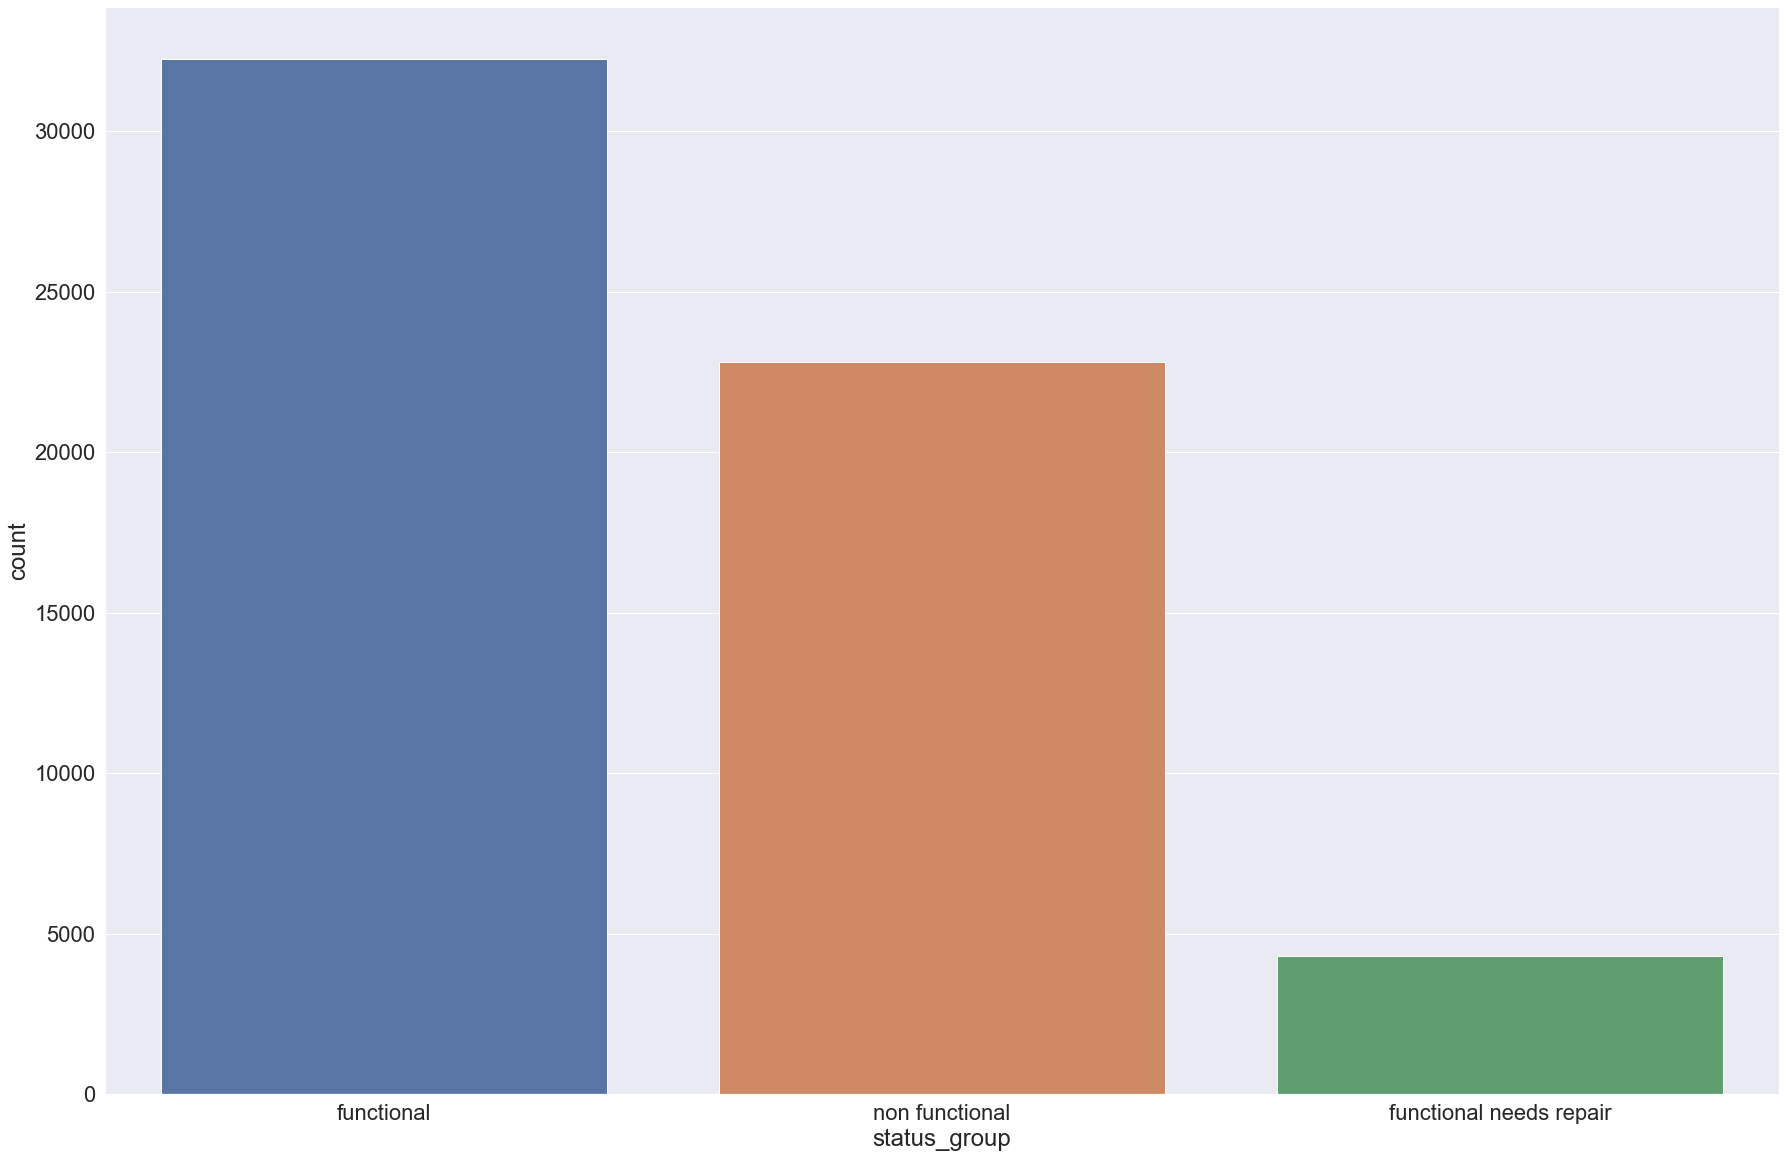

In [5]:
sns.countplot('status_group', data = training_labels)
plt.rcParams["figure.figsize"] = (30,30)
plt.show()

## The distribution is unequal and we will have to decide on classification metrics for comparing models

- http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#the-average-precision-score-in-multi-label-settings

# 1. Data Cleaning

## Inspecting Cardinality of Categorical Data

In [6]:
cat_df = pd.DataFrame(columns=["Feature", "Cardinality","% Missings"])

total_cardinality = 0

i=0

for col in train.columns:
    if (train[col].dtype == np.object):
        cat_df.loc[i,"Feature"] = col
        cat_df.loc[i,"Cardinality"] = len(train[col].unique())
        total_cardinality += len(train[col].unique())
        pct_of_missing_values = float((len(train[col]) - train[col].count()) / len(train[col]))
        cat_df.loc[i,"% Missings"] = pct_of_missing_values*100
        i+=1

print("Total cardinality of categorical features:",total_cardinality)

display(cat_df)

Total cardinality of categorical features: 66178


,Feature,Cardinality,% Missings
0,date_recorded,356,0.0
1,funder,1898,6.119529
2,installer,2146,6.153199
3,wpt_name,37400,0.0
4,basin,9,0.0
5,subvillage,19288,0.624579
6,region,21,0.0
7,lga,125,0.0
8,ward,2092,0.0
9,public_meeting,3,5.612795


In [7]:
#Combining Training and Testing Data for ease of imputations and feature engineering
combineddf=pd.concat([train,test],axis=0,ignore_index=True)
combineddf.head(5)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


## Dropping categories with too few or too many factor levels

In [8]:

combineddf.drop(['wpt_name',    # too many levels 
    'subvillage',  # too many levels; we have lat and long for location
    'ward',        # too many levels; we have lat and long for location
    'recorded_by', # constant
    'scheme_name', # too many levels
    'num_private', # irrelevant
    'region_code', # too many levels; we have lat and long for location
    'quantity_group', #same as quantity column
    'source_type',   #same as source but with fewer levels
    'waterpoint_type_group', #same as waterpoint
    'payment_type'],   #same as payment
              axis=1, inplace=True)

combineddf.shape

(74250, 29)

In [9]:
combinedtemp= combineddf['construction_year'].replace(0,nan)
combinedtemp1=combinedtemp.dropna(how='all',axis=0)
combinedtemp1.median()
#We will use this to replace 0's in construction year in the combined df

2000.0

In [10]:
combinedtemp2= combineddf['gps_height'].replace(0,nan)
combinedtemp3=combinedtemp2.dropna(how='all',axis=0)
combinedtemp3.median()
#We will use this to replace 0's in gps height in the combined df

1166.0

### Replacing Na's, Extracting Features and Converting Datatypes for better representation

In [11]:
#Replace Na's with 0 
combineddf['funder'].replace(nan,0, inplace= True)
combineddf['installer'].replace(nan,0, inplace= True)
combineddf['permit'].replace(nan,0, inplace= True)
combineddf['scheme_management'].replace(nan,0, inplace= True)

#contains True or False values
combineddf['public_meeting'].fillna(value=True, inplace=True)

#Replace 0's with arbitrary categories
combineddf['permit'].replace("0","TRUE", inplace= True) #corresponding to 0's almost entirely not pay to use - so let's consider as True
combineddf['public_meeting'].replace("0","TRUE", inplace= True)
combineddf['scheme_management'].replace(0, "Unknown", inplace=True)  #large number of Blanks - cannot fit this into None or Other group
combineddf['funder'].replace(0, "Other", inplace=True)
combineddf['installer'].replace(0, "Other", inplace=True)
combineddf['installer'].replace('-', "Other", inplace=True)
combineddf['construction_year'].replace(0, 2000, inplace=True) #median value for values aside from 0
combineddf['gps_height'].replace(0, 1166, inplace=True)        #median value for values aside from 0

combineddf['date_recorded'] = pd.to_datetime(combineddf['date_recorded'])   #converting date_recorded into number of days since first recorded date
combineddf['date_recorded'] = (combineddf['date_recorded'] - combineddf['date_recorded'].min()) / np.timedelta64(1, 'D')

#Type-conversion
combineddf['population']=combineddf['population'].astype('float64')  #we all float down here         
combineddf['gps_height']=combineddf['gps_height'].astype('float64') 
combineddf['construction_year']=combineddf['construction_year'].astype('float64')
combineddf['amount_tsh']=combineddf['amount_tsh'].astype('float64')

In [12]:
#Define function to replace repeating values under common levels within extracting type - make extraction type group obsolete
def clean_values(combineddf, col, values_dict):
    for k, v in values_dict.items():
        combineddf.loc[combineddf[col] == k, col] = v

#Define key-value pairs for replacing        
clean_values(combineddf, 'extraction_type',
    {
        'india mark ii'             : 'india',
        'india mark iii'            : 'india',
        'other - swn 81'            : 'swn',
        'swn 80'                    : 'swn',
        'other - play pump'         : 'other handpump',
        'walimi'                    : 'other handpump',
        'other - mkulima/shinyanga' : 'other handpump',
        'cemo'                      : 'other motorpump',
        'climax'                    : 'other motorpump',
    }
)


#Drop 'extraction_type_group'
combineddf.drop(['extraction_type_group'],axis=1, inplace=True)
combineddf.shape


(74250, 28)

In [36]:
#plt.plot(combineddf[:train.shape[0]].extraction_type, training_labels.status_group)
combineddf[:train.shape[0]].extraction_type, training_labels.loc[training_labels['status_group'] == 'non functional']

(0            gravity
 1            gravity
 2            gravity
 3        submersible
 4            gravity
             ...     
 59395        gravity
 59396        gravity
 59397            swn
 59398    nira/tanira
 59399    nira/tanira
 Name: extraction_type, Length: 59400, dtype: object,
           id    status_group
 3      67743  non functional
 6      19816  non functional
 7      54551  non functional
 8      53934  non functional
 16     48451  non functional
 ...      ...             ...
 59382  47002  non functional
 59384  72148  non functional
 59391  44885  non functional
 59392  40607  non functional
 59394  11164  non functional
 
 [22824 rows x 2 columns])

In [37]:
temp_df_vis = combineddf[:train.shape[0]]

In [39]:
temp_df_vis['status_group'] = training_labels.status_group

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(0, 0, 'gravity'),
  Text(1, 0, 'other'),
  Text(2, 0, 'nira/tanira'),
  Text(3, 0, 'submersible'),
  Text(4, 0, 'mono'),
  Text(5, 0, 'swn'),
  Text(6, 0, 'india'),
  Text(7, 0, 'ksb'),
  Text(8, 0, 'afridev'),
  Text(9, 0, 'other - rope pump'),
  Text(10, 0, 'other handpump'),
  Text(11, 0, 'windmill'),
  Text(12, 0, 'other motorpump')])

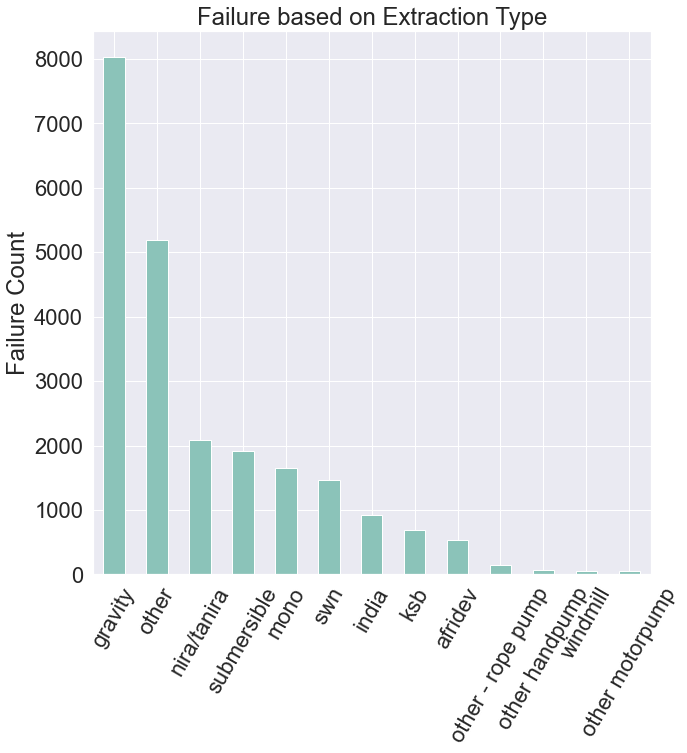

In [89]:
plt.figure(figsize = (10,10))
#temp_df_vis.loc[temp_df_vis['status_group']=='non functional']['extraction_type'].unique(),
temp_df_vis.loc[temp_df_vis['status_group']=='non functional']['extraction_type'].value_counts().plot(kind  = 'bar',  color='#8bc3b9')
plt.title('Failure based on Extraction Type')
plt.ylabel('Failure Count')
plt.xticks(rotation=60)

<AxesSubplot:>

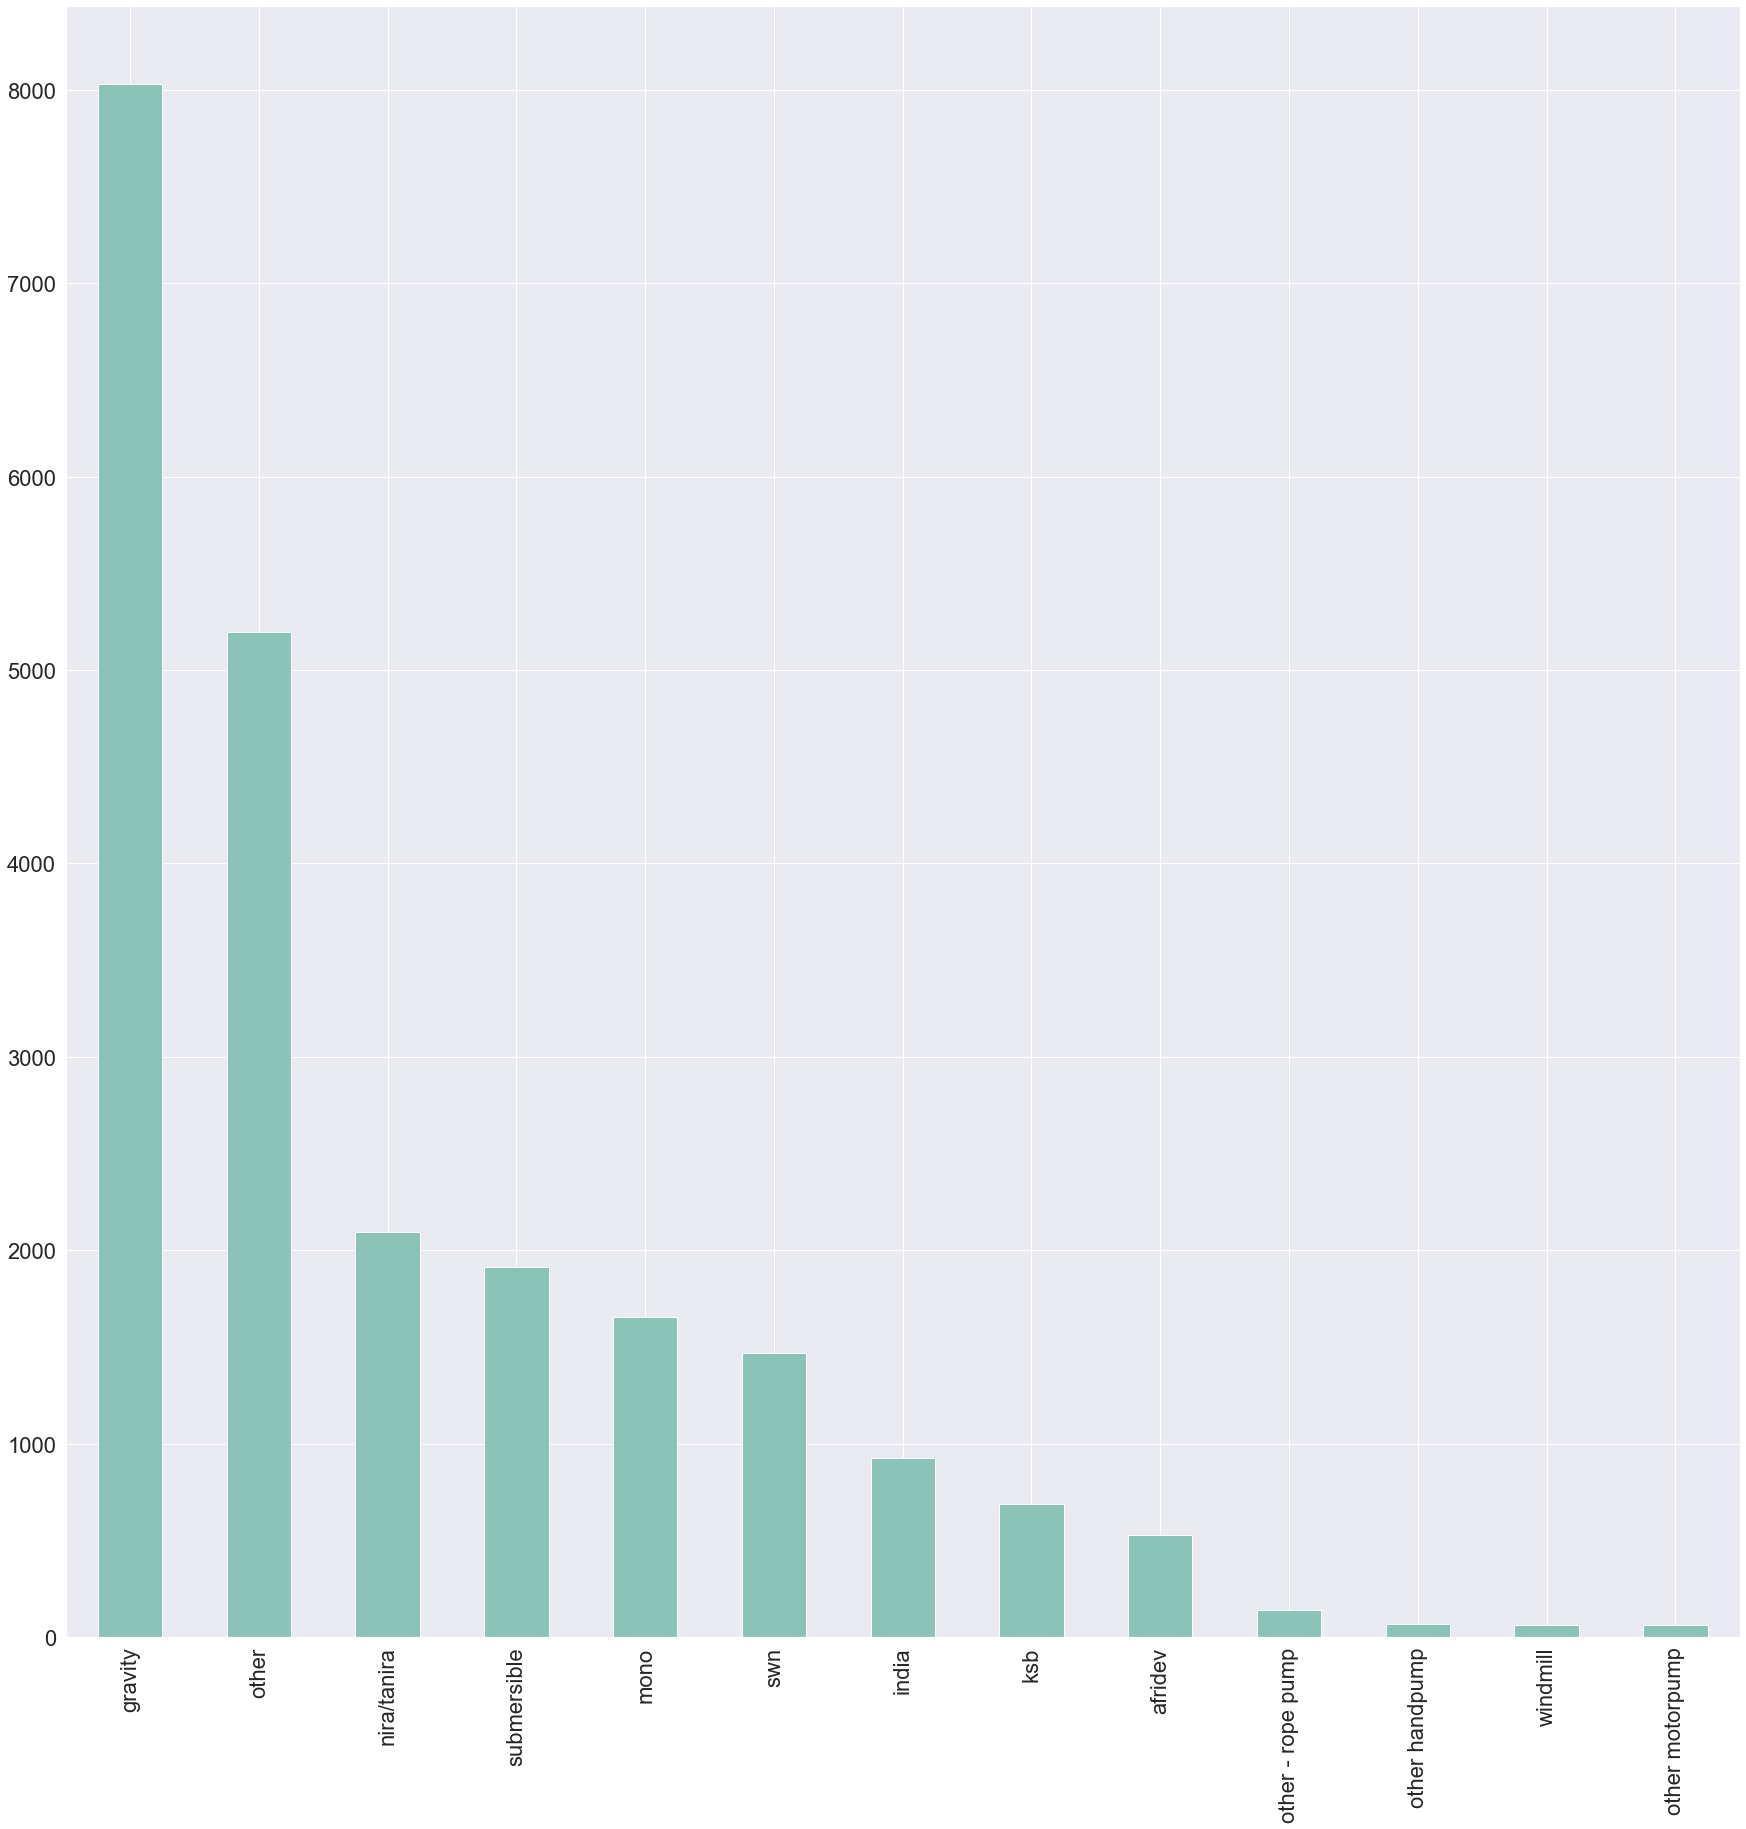

In [88]:
temp_df_vis.loc[temp_df_vis['status_group']=='non functional']['extraction_type'].value_counts().plot(kind  = 'bar',  color='#8bc3b9')

In [71]:
 temp_df_vis.loc[temp_df_vis['status_group']=='non functional']['extraction_type'].value_counts()

gravity              8031
other                5195
nira/tanira          2092
submersible          1911
mono                 1654
swn                  1470
india                 926
ksb                   686
afridev               528
other - rope pump     141
other handpump         70
windmill               60
other motorpump        60
Name: extraction_type, dtype: int64

In [ ]:
temp_df_vis.loc[temp_df_vis['status_group']=='non functional']['extraction_type']

In [70]:
22824/59400

0.3842424242424242

In [23]:
#Latitude and Longitude to cartesian coordinates
# Assuming Earth as sphere not ellipsoid 
def cartesian_x(lat,lon):
    lat=radians(lat)
    lon=radians(lon)
    R=6371.0
    x = R * cos(lat) * cos(lon)
    return x
def cartesian_y(lat,lon):
    lat=radians(lat)
    lon=radians(lon)
    R=6371.0
    y = R * cos(lat) * sin(lon)
    return y

# extracting cartesian x,y cordinates form latitude and longitude
combineddf['x1']=[cartesian_x(i,j) for i,j in zip(combineddf['latitude'],combineddf['longitude'])]
combineddf['y1']=[cartesian_y(i,j) for i,j in zip(combineddf['latitude'],combineddf['longitude'])]

#Manhattan distance as a new feature
#combineddf['Manhattan_dist'] =(combineddf['x1']).abs() +(combineddf['y1']).abs()    


In [24]:
combineddf.drop(['latitude',    
    'longitude' 
    #,'x1',       
    #'y1'
                ], axis=1, inplace=True)

In [25]:
display(combineddf['funder'].describe())

count                      74250
unique                      2141
top       Government Of Tanzania
freq                       11299
Name: funder, dtype: object

In [34]:
#Listing Categorical columns for label encoding
cat_cols=combineddf.select_dtypes(include=['object']).columns.values.tolist()
cat_cols

['funder',
 'installer',
 'basin',
 'region',
 'lga',
 'scheme_management',
 'permit',
 'extraction_type',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'water_quality',
 'quality_group',
 'quantity',
 'source',
 'source_class',
 'waterpoint_type']

### Treating Categorical and Numerical Features

In [35]:
#Listing numerical columns for scaling
num_cols=combineddf.select_dtypes(include=['int64', 'float64']).columns.values.tolist()
num_cols

['id',
 'amount_tsh',
 'date_recorded',
 'gps_height',
 'district_code',
 'population',
 'construction_year',
 'x1',
 'y1']

In [36]:
#Listing Categorical columns for label encoding
cols=('basin',
 'extraction_type',
 'extraction_type_class',
 'lga',
 'management',
 'management_group',
 'payment',
 'permit',
 'quality_group',
 'quantity',
 'region',
 'scheme_management',
 'source',
 'source_class',
 'water_quality',
 'waterpoint_type',
 'public_meeting', 
 'funder', 
 'installer')  #need to encode funder and installer to pass through models

# Applying Label Encoding
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(combineddf[c].values)) 
    combineddf[c] = lbl.transform(list(combineddf[c].values))
    
###########################
#funder and installer had too many levels; going back to format them as function of frequency
###########################
combineddf.shape

(74250, 28)

In [37]:
combineddf.dtypes

id                         int64
amount_tsh               float64
date_recorded            float64
funder                     int64
gps_height               float64
installer                  int64
basin                      int64
region                     int64
district_code              int64
lga                        int64
population               float64
public_meeting             int64
scheme_management          int64
permit                     int64
construction_year        float64
extraction_type            int64
extraction_type_class      int64
management                 int64
management_group           int64
payment                    int64
water_quality              int64
quality_group              int64
quantity                   int64
source                     int64
source_class               int64
waterpoint_type            int64
x1                       float64
y1                       float64
dtype: object

In [38]:
# Scaling numeric features
scaler = StandardScaler()
numeric_features = combineddf.select_dtypes(include=np.float64)

scaler.fit(numeric_features)
combineddf[numeric_features.columns] = scaler.transform(combineddf[numeric_features.columns])

display(combineddf[numeric_features.columns].head())
        

,amount_tsh,date_recorded,gps_height,population,construction_year,x1,y1
0,1.954529,-1.135218,0.641710,-0.152310,0.102017,-0.228950,0.099044
1,-0.109637,1.022350,0.659671,0.210683,1.186609,0.100521,0.143227
2,-0.101036,0.995492,-0.763253,0.147000,1.088010,-0.600067,0.506358
3,-0.109637,0.911935,-1.607428,-0.260572,-1.179773,-1.169513,0.541744
4,-0.109637,-0.774131,0.194676,-0.383692,0.200617,0.905419,-0.354902


In [39]:
#Encoding status_group of train to pass it through our models
y = training_labels.status_group
LEncoder = LabelEncoder()
LEncoder.fit(y)
labels = LEncoder.transform(y)
print(LEncoder.classes_)

['functional' 'functional needs repair' 'non functional']


In [40]:
display(labels)

array([0, 0, 0, ..., 0, 0, 0])

#### Preparing Training, Validation and Test Data for Modeling

In [41]:
x = combineddf[:train.shape[0]]
test_data = combineddf[train.shape[0]:]

In [42]:
x.to_csv("pythonoutputtrain.csv")
test_data.to_csv("pythonoutputtest.csv")

In [44]:
test_data.drop(['id'],axis=1, inplace=True)

In [45]:
temp_forid = combineddf[train.shape[0]:]
test_ids= temp_forid.id

In [46]:
# Split training and validation data
x, labels = shuffle(x, labels, random_state= 10)
X_train, X_valid, y_train, y_valid = train_test_split(x, labels, train_size=0.8, random_state=10)

# 2. Building Models with prepared data

## Base Random Forest Model

In [47]:
RF_model = RandomForestClassifier(n_estimators=1000)
RF_model.fit(X_train, y_train)
y_pred = RF_model.predict(X_valid)

In [85]:
#Accuracy on validation data
acc=accuracy_score(y_valid, y_pred)
fscore = fbeta_score(y_valid, y_pred, average='weighted', beta=0.5)
from sklearn.metrics import classification_report
print(classification_report(y_valid, y_pred))
print('RF Accuracy:', acc)
print('RF Fbeta score:', fscore)

#this is my base model - score was ~80.1 with this on the leaderboard.Not going with this for final submission unless I do an ensemble; used it to infer feature importances
#manhattan distance has lower importance than latitude longitude (based on past trials)
#but it's represented better, so will keep manhattan distance as is; plus CatBoost performs better with this feature than lat and long

#Finally decided to remove Manhattan distance and just keep the cartesian coordinates, because catboost did not perform well

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      6438
           1       0.50      0.35      0.41       860
           2       0.84      0.79      0.81      4582

    accuracy                           0.81     11880
   macro avg       0.72      0.67      0.69     11880
weighted avg       0.80      0.81      0.80     11880

RF Accuracy: 0.8056397306397306
RF Fbeta score: 0.7994535323594603


<AxesSubplot:>

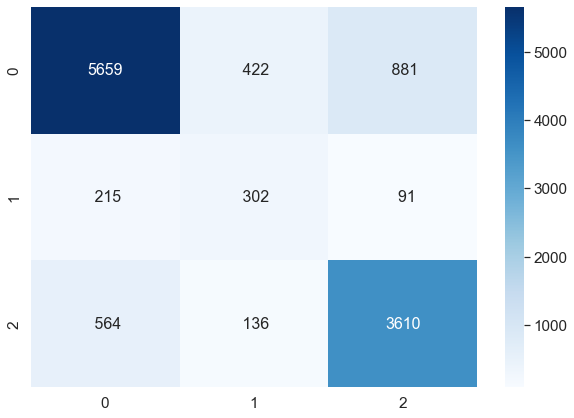

In [77]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_matrix(y_pred, y_valid), cmap="Blues", fmt = "4", annot=True,annot_kws={"size": 16})

Index(['quantity', 'x1', 'y1', 'date_recorded', 'gps_height',
       'waterpoint_type', 'construction_year', 'population', 'funder',
       'installer'],
      dtype='object')


<AxesSubplot:>

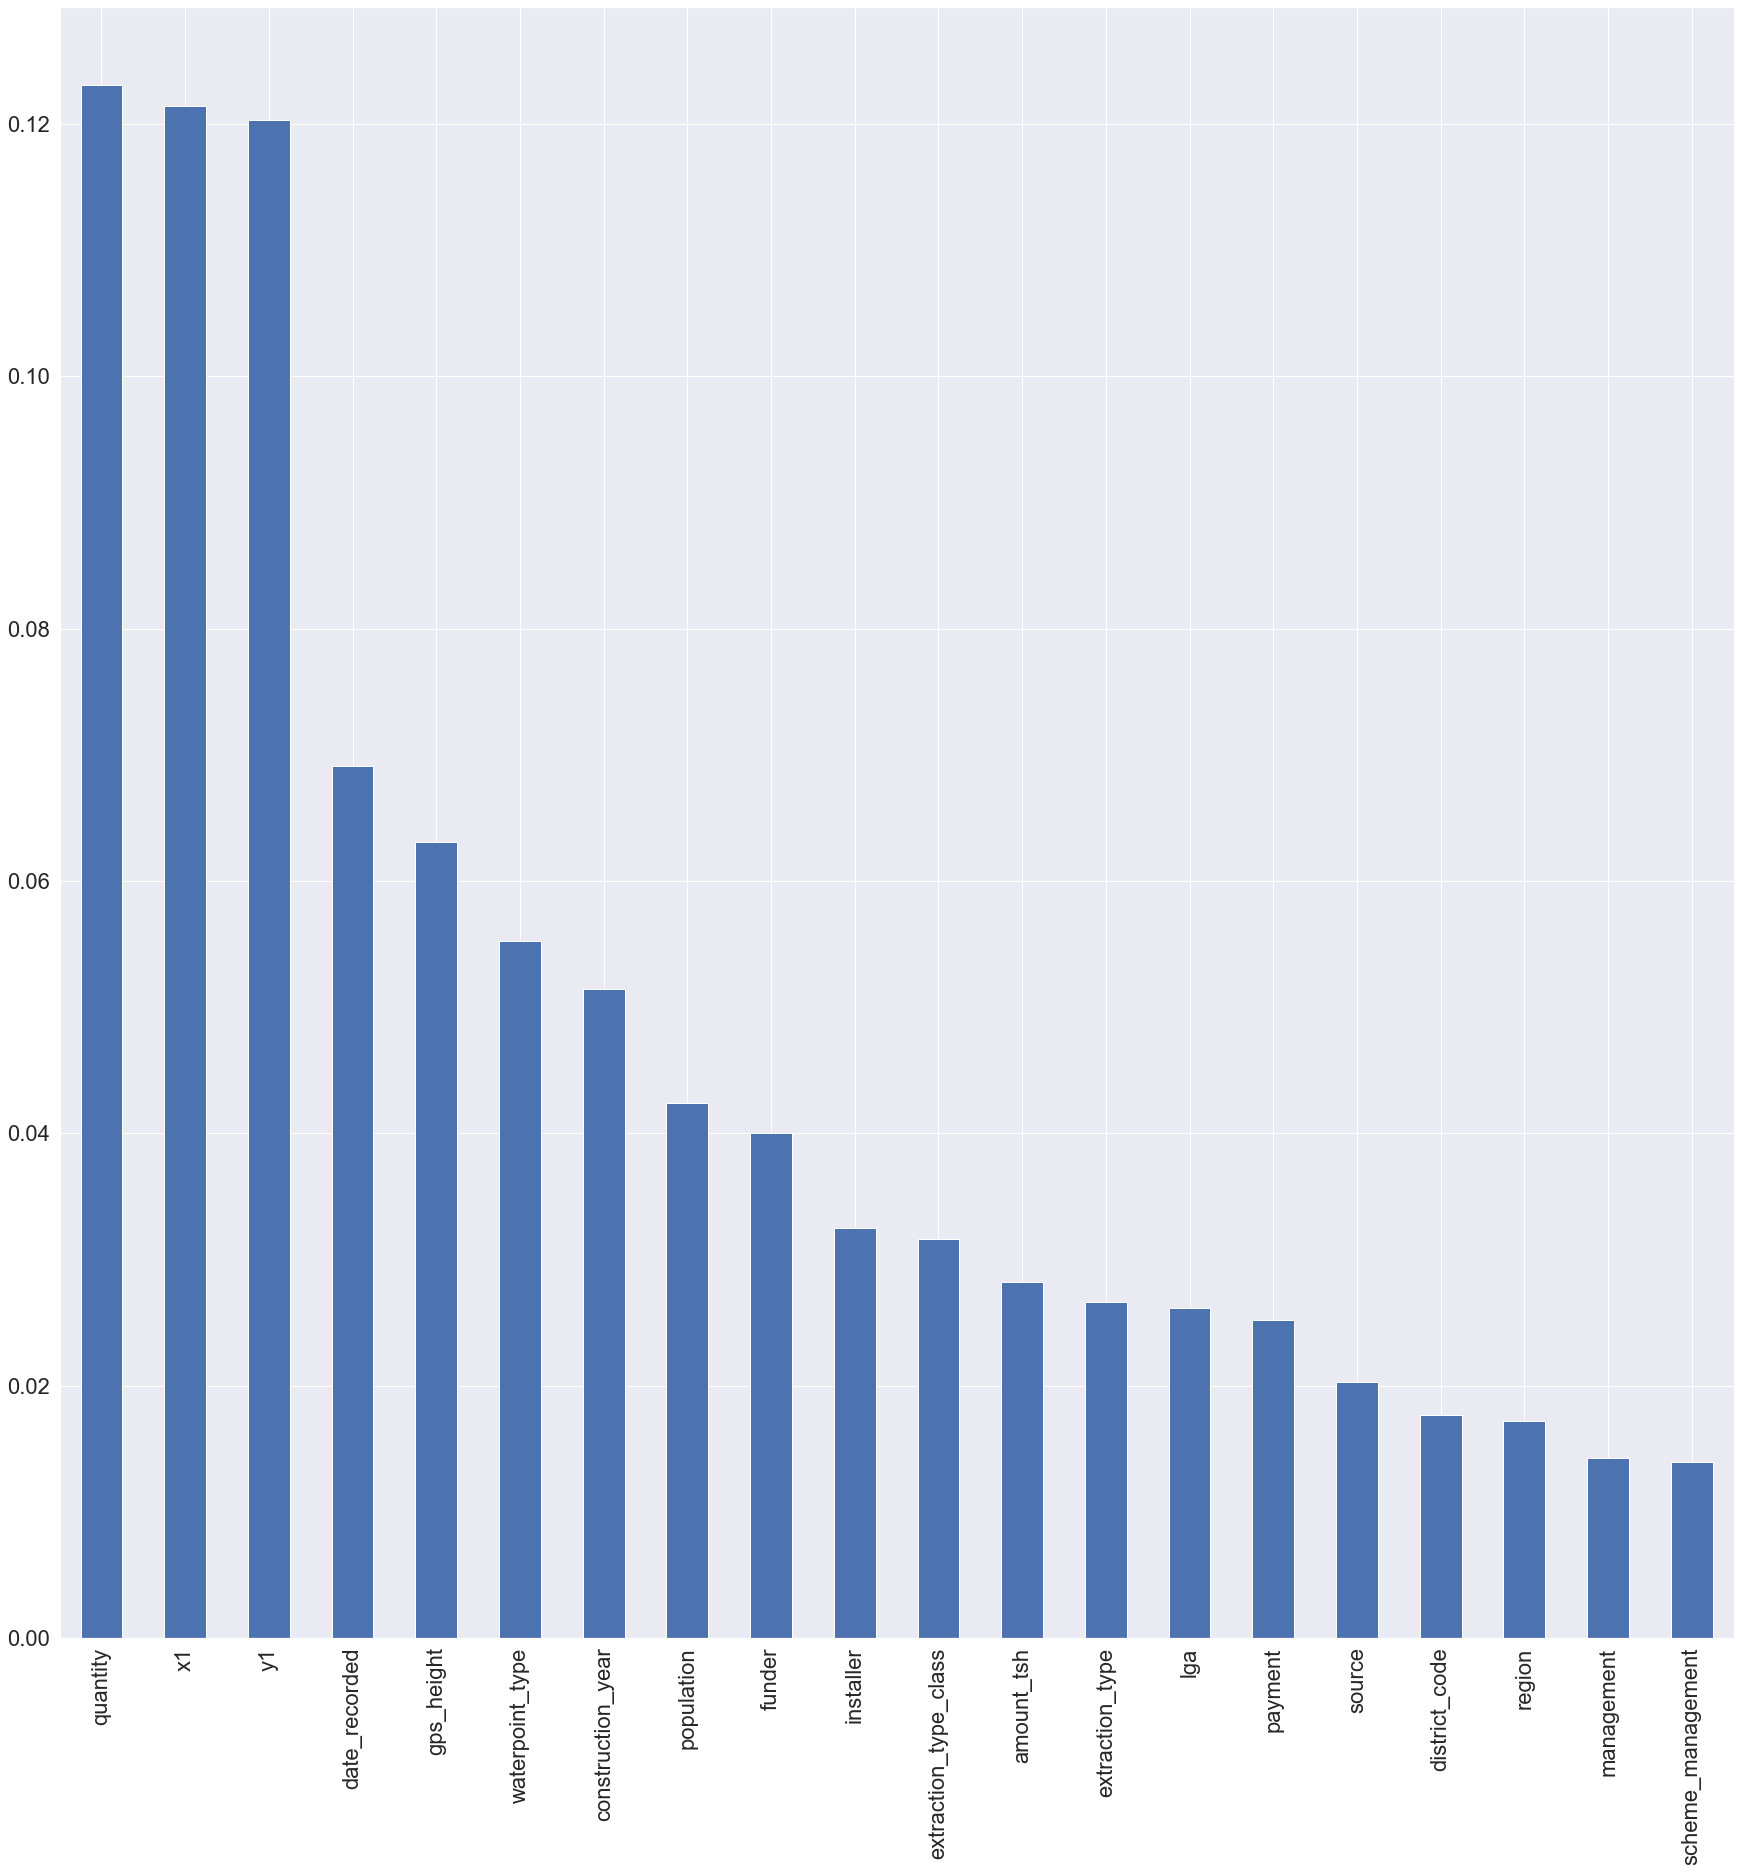

In [49]:
features = RF_model.feature_importances_
imp_features = np.argsort(features)[::-1]
k = 20
print(x[:train.shape[0]].columns[imp_features[:10]])
series_imp_features = pd.Series(features[imp_features[:k]], x[:train.shape[0]].columns[imp_features[:k]])
series_imp_features.plot(kind='bar')

## CatBoost Model

In [ ]:
cbc= CatBoostClassifier(
    learning_rate=0.1,
    loss_function='MultiClass', 
    calc_feature_importance=True,
    eval_metric='Accuracy',
    od_pval=0.01,
    random_seed=10
)

In [ ]:
cbc.fit(X_train, y_train)

In [ ]:
#Validation score with CatBoost
print('Train: {:.4f}'.format(
    cbc.score(X_train, y_train)
))

In [ ]:
x.columns.values

In [ ]:
ctrs= ['basin', 'construction_year',
       'district_code', 'extraction_type', 'extraction_type_class',
        'lga', 'management', 'management_group', 'payment',
       'permit', 'public_meeting', 'quality_group',
       'quantity', 'region', 'scheme_management', 'source',
       'source_class', 'water_quality', 'waterpoint_type', 
       'funder', 'installer'] #adding funder and installer as categories again; representing them as function of frequencies did not help with catboost

In [ ]:
ctrs_indexes = []
for i, v in enumerate(features):
    if v in ctrs:
        ctrs_indexes.append(i)

In [ ]:
#fitting whole train set
cbc = CatBoostClassifier(
    learning_rate=0.1,
    loss_function='MultiClass', 
    eval_metric='Accuracy',
).fit(x, labels, cat_features= ctrs_indexes)   #got over-fitted model when features was not specified; possibly because it considers everything as a category by default

In [ ]:
def submit(pred, name='ans_catboost'):
    y_pred = LEncoder.inverse_transform(pred.astype(int))
    ans_catboost = pd.DataFrame({'id': test_ids, 'status_group': y_pred.ravel()})
    ans_catboost.to_csv('submissions/' + name + '.csv', index=False)      

In [ ]:
submit(cbc.predict(test_data))  

#tried hyperparameter optimization; catboost does not perform well for multiclass, especially with mixed categorical and numerical types
#level of tuning required outweighed by performance and ease of use of other base models
#even RandomForest performed better in this case, so moving onto XGBoost

### XGBoost - Base Model - scored 82.01 on Leaderboard; Ensemble of RF, XGB scored highest at 82.84

In [50]:
param = {'booster': 'gbtree',
        'obective': 'multi:softmax',
        'eta': 0.025,
        'max_depth': 23,
        'colsample_bytree': 0.4,
        'silent': 1,
        'eval_metric': 'mlogloss',
        'num_class': 3
        }

In [51]:
train_dmatrix = xgb.DMatrix(x, label=labels, missing=np.nan)

In [52]:
clf = xgb.train(param, dtrain=train_dmatrix, num_boost_round=400, maximize=False)

[09:46:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "obective", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [64]:
print(train_dmatrix.feature_names)

['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'basin', 'region', 'district_code', 'lga', 'population', 'public_meeting', 'scheme_management', 'permit', 'construction_year', 'extraction_type', 'extraction_type_class', 'management', 'management_group', 'payment', 'water_quality', 'quality_group', 'quantity', 'source', 'source_class', 'waterpoint_type', 'x1', 'y1']


<bound method Booster.get_fscore of <xgboost.core.Booster object at 0x12f23bf90>>

In [54]:
#test_data.drop(['status_group'],axis=1, inplace=True)
test_dmatrix = xgb.DMatrix(test_data, missing=np.nan)

In [57]:
def submit(pred, name='ans_xgb'):
    y_pred = LEncoder.inverse_transform(pred.astype(int))
    ans_xgb = pd.DataFrame({'id': test_ids, 'status_group': y_pred.ravel()})
    ans_xgb.to_csv( name + '.csv', index=False)      

In [58]:
submit(clf.predict(test_dmatrix))  

In [59]:
importances = clf.get_fscore()
importances = sorted(importances.items(), key=operator.itemgetter(1))

Text(0.5, 0, 'relative importance')

<Figure size 2160x2160 with 0 Axes>

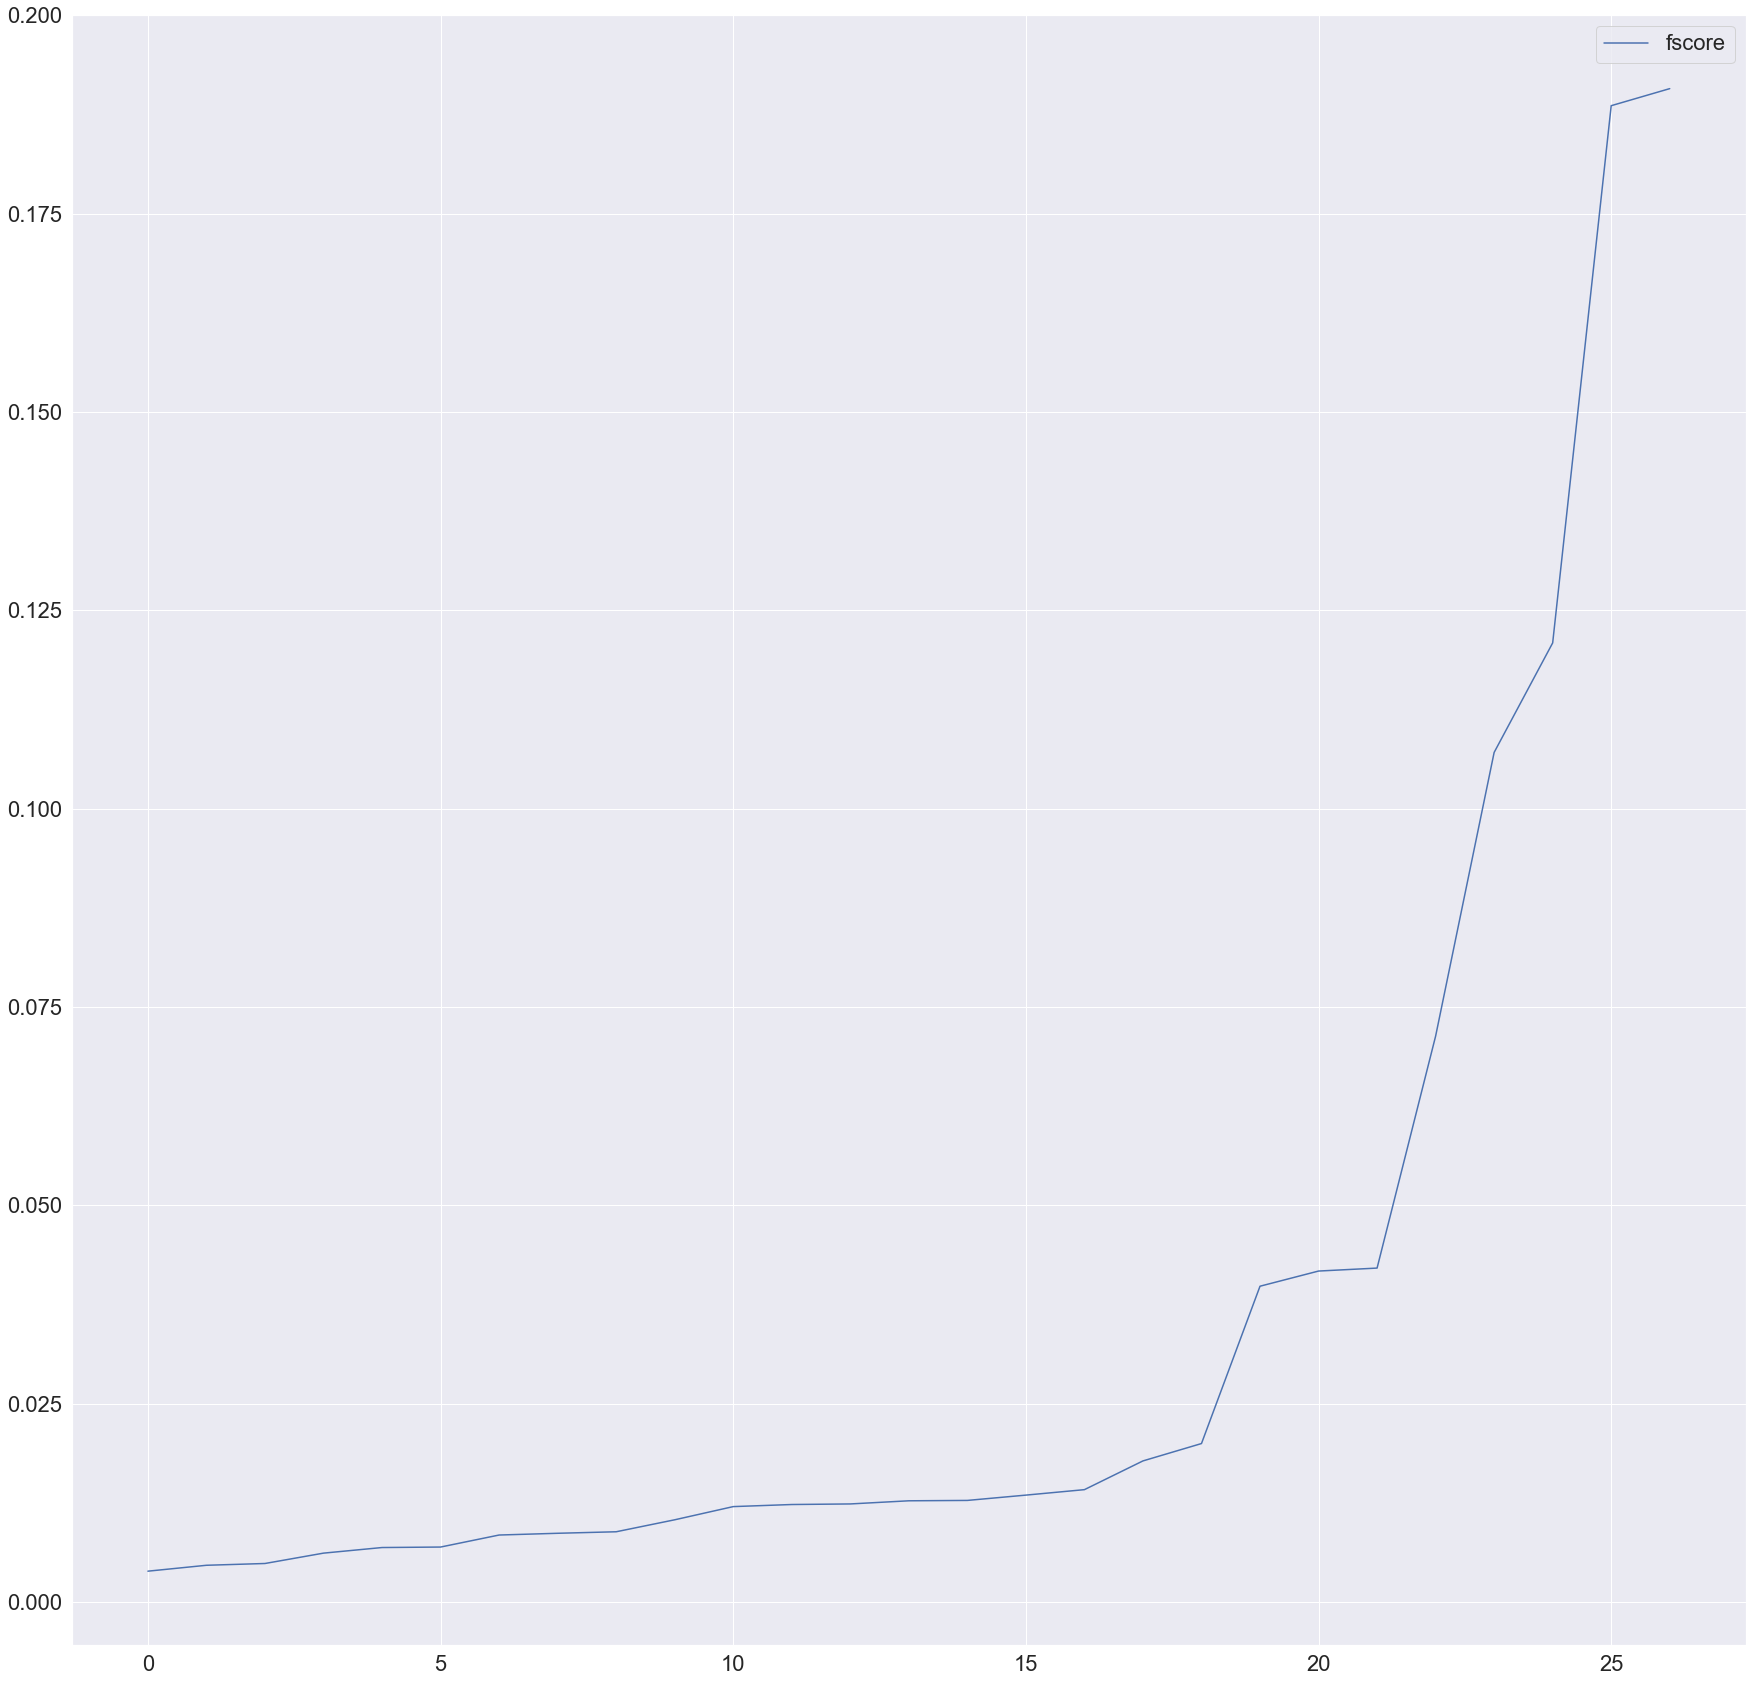

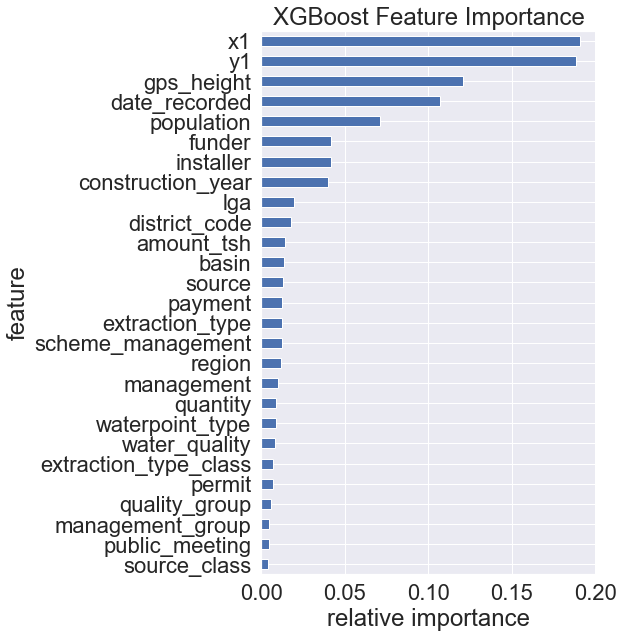

In [60]:
temp = pd.DataFrame(importances, columns=['feature', 'fscore'])
temp['fscore'] = temp['fscore'] / temp['fscore'].sum()
plt.figure()
temp.plot()
temp.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')

# Used Bayesian-optimization for hyperparameter search 

#Did this on Cloud Datalab on n1-highcpu-16; but maxed out the utilization so was only able to take a few parameters from the entire grid


Step |   Time |      Value |   colsample_bytree |     gamma |   learning_rate |   max_depth |   min_child_weight |   n_estimators |   reg_alpha |   reg_lambda |   subsample | 

  25 | 06m36s |    0.80988 |             0.3645 |    0.0106 |          0.0622 |     21.2614 |            18.4682 |       596.4880 |      0.0463 |       8.1202 |      0.9928 |
  
  
  31 | 05m26s |    0.81015 |             0.6716 |    0.0354 |          0.0486 |     19.3704 |            19.2455 |       591.0918 |      6.0458 |       8.8225 |      0.9842 |


In [ ]:
#Defining function for optimizing XGBoost - can also do this for other models like RF
def xgbcv(max_depth,  
          learning_rate, 
          n_estimators,
          min_child_weight,
          gamma,
          subsample,
          colsample_bytree,
          reg_alpha, 
          reg_lambda,
          silent=True):
    return cv_s(xgb.XGBClassifier(max_depth=int(max_depth),
                                 learning_rate=learning_rate,
                                 n_estimators=int(n_estimators),
                                 gamma=gamma,
                                 reg_alpha=reg_alpha,
                                 min_child_weight=min_child_weight,
                                 objective='multi:softmax'),
                    x,
                    labels,
                    "accuracy",
                    cv=4).mean() 

##Setting range of parameters for optimization
xgboostBO = BayesOpt(xgbcv,
                                 {
                                  'max_depth': (4,23),
                                  'learning_rate': (0.01, 0.2),
                                  'n_estimators': (200,600),
                                  'gamma': (0.01, 10),
                                  'min_child_weight': (1,40),
                                  'subsample': (0.2, 1),
                                  'colsample_bytree' :(0.2, 1),
                                  'reg_alpha':(0, 10),
                                  'reg_lambda':(0, 10)
                                  })                                


In [ ]:
print ("Start Optimization of Main Model")
xgboostBO.maximize(init_points=10,n_iter=110, xi=0.0,  acq="poi")

In [ ]:
#Best parameters from Bayes-opt for accuracy as a metric
param = {
                  'max_depth' : 19,
                  'learning_rate': 0.0486,
                  #'n_estimators': 591,  #removed and mentioned as num_boost_round; same thing
                  'gamma': 0.0354,
                  'min_child_weight': 19.2455,
                  'subsample': 0.9842,
                  'colsample_bytree': 0.6716,
                  'reg_alpha': 6.0458,
                  'objective':'multi:softmax',
                  'num_class': 3,
                  'eval_metric': 'mlogloss'
        }


In [ ]:
clf_final = xgb.train(param, dtrain=train_dmatrix, num_boost_round=591, maximize=False)

In [ ]:
def submit(pred, name='ans_xgb_final'):
    y_pred = LEncoder.inverse_transform(pred.astype(int))
    ans_xgb_final = pd.DataFrame({'id': test_ids, 'status_group': y_pred.ravel()})
    ans_xgb_final.to_csv('submissions/' + name + '.csv', index=False)     

In [ ]:
submit(clf.predict(test_dmatrix))  

In [ ]:
importances = clf_final.get_fscore()
importances = sorted(importances.items(), key=operator.itemgetter(1))

In [ ]:
temp = pd.DataFrame(importances, columns=['feature', 'fscore'])
temp['fscore'] = temp['fscore'] / temp['fscore'].sum()
plt.figure()
temp.plot()
temp.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')

# Results:
- Here, I've compared resuts of individual models.

- The best model obtained was by manually stacking XGBoost and RF in excel and it scored 82.84.

- f-score is not the best metric for comparison here (because of unequal classes) as observed through the Base XGBoost and Optimized one, where importance of features completely shifts based on evaluation metric and parameters. 

- There are clear differences between different models optimized for different evaluation metrics.

- Because of this, I conclude that the best possible model for this case is a Stacked one with multiple models; 
  with Bayesian Optimization done for Bagging and Boosting models, eg: both RF and XGBoost, under evaluation metrics - Accuracy and Log Loss
  
Other observations:
- Training and validating a single configuration often takes several hours with Bayesian Optimization, which limits the achievable performance, especially on limited availability of processing power. 